# Robust Shapley values - robust explanation of an aggregated radiomic model with non-optional regions
In this jupyter notebook we provide a short example for the use of **robust Shapley values** to explain aggregated radiomic models that integrate non-optional regions (i.e. regions that will lead to invalid aggregated inputs when removed). 

We study the classification of the histological subtype of non-small cell lung cancer (NSCLC) from baseline 18F-FDG PET images. To do so, we use a radiomic model that aggregates features extracted from all the metastases of the patient as well as the mean SUV in a healthy region of the liver and the mean SUV in a healthy region of the spleen. For more details please refer to [this notebook](https://github.com/ncaptier/radshap/blob/main/examples/nsclc_subtype_classification.ipynb) which deals with a very similar study.

In [1]:
%load_ext autoreload
%autoreload 2

# Setup for local running - please delete this block
import sys
sys.path.append('C:\\Users\\ncaptier\\Documents\\GitHub\\radshap')

import collections
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, recall_score, balanced_accuracy_score
from sklearn.base import clone

from radshap.shapley import RobustShapley
from radshap.plot import plot_bars, plot_pet

## 0. Load radiomic and clinical data

Our cohort gathers **110 NSCLC metastatic patients** with a baseline 18F-FDG PET scan (for the diagnosis of the metastatic disease) acquired before the beginning of their first line treatment. All their metastases were segmented by a 12 years experienced nuclear medicine physician. Please refer to [this notebook](https://github.com/ncaptier/radshap/blob/main/examples/nsclc_subtype_classification.ipynb) for all the necessary details about the data.

In [2]:
df_clinicals = pd.read_csv("..\\data\\data_clinicals.csv", index_col=0)

df_radiomics_all = pd.read_csv("..\\data\\data_allmeta_liverspleen.csv", index_col=0)

# we log-transform the volume feature to avoid linear model to deal with highly right skewed distributions
df_radiomics_all.loc[:, "original_shape_VoxelVolume"] = df_radiomics_all["original_shape_VoxelVolume"].apply(lambda x: np.log(x+1))

## 1. Train and test the aggregated model

Here we train and test a classifier which takes as input the minimum value, the maximum value, and the standard deviation of the 10 extracted radiomic features over all the metastases of the patient, as well as the SUVmean of an healthy region within the liver and the SUVmean of an healthy region within the spleen.

### 1.1 Aggregate features with min, max, and std

**Note:** We reorder the features to facilitate the application of our RobustShapley function. Please refer to [this notebook](https://github.com/ncaptier/radshap/blob/main/examples/nsclc_subtype_classification.ipynb) for more details.

In [3]:
def reorder_columns(columns, function_names):
    d = {f_name: [] for f_name in function_names}
    for col in columns:
        d[col[1]].append(col)    
    return sum(d.values(), [])

In [4]:
fun_std = lambda x: x.std(ddof=0) #ddof is set to 0 to normalize by N and not N-1 and thus handle the cases where there is only one lesion
fun_std.__name__ = "std"

mask_liverspleen = df_radiomics_all["localization"].isin(["Liver", "Spleen"])
df_agg = df_radiomics_all[~mask_liverspleen].iloc[:, 2:].groupby(level=0).agg(("max", "min", fun_std)).loc[df_clinicals.index]

#reorder columns
df_agg = df_agg[reorder_columns(df_agg.columns, function_names = ("max", "min", "std"))]
df_agg.columns = df_agg.columns.map('_'.join)

df_agg["liver_SUVMean"] = df_radiomics_all[df_radiomics_all["localization"]== "Liver"]["original_firstorder_Mean"]
df_agg["spleen_SUVMean"] = df_radiomics_all[df_radiomics_all["localization"]== "Spleen"]["original_firstorder_Mean"]

df_agg.head()

,original_shape_Sphericity_max,original_shape_Elongation_max,original_shape_Flatness_max,original_shape_VoxelVolume_max,original_firstorder_Entropy_max,original_firstorder_Kurtosis_max,original_firstorder_Maximum_max,original_firstorder_Mean_max,original_firstorder_QuartileDispersion_max,original_firstorder_Skewness_max,...,original_shape_Flatness_std,original_shape_VoxelVolume_std,original_firstorder_Entropy_std,original_firstorder_Kurtosis_std,original_firstorder_Maximum_std,original_firstorder_Mean_std,original_firstorder_QuartileDispersion_std,original_firstorder_Skewness_std,liver_SUVMean,spleen_SUVMean
OCTOID,,,,,,,,,,,,,,,,,,,,,
patient_0,0.863482,0.942119,0.830428,2.473464,4.209365,22.400791,13.207974,4.781307,0.290141,3.597876,...,0.177240,0.096137,0.726723,7.276279,3.289046,0.626308,0.071618,1.105949,2.388668,1.700440
patient_1,0.837041,0.900909,0.596313,2.443369,4.305888,5.855306,10.006734,4.819726,0.283288,1.707722,...,0.117702,0.144899,0.537648,1.340308,1.941857,0.531018,0.054307,0.387661,2.413486,2.199252
patient_2,0.780999,0.705620,0.581406,2.302411,3.800767,2.483848,7.343111,4.192277,0.211119,0.623496,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.050283,2.036781
patient_3,0.867612,0.825841,0.696419,2.560575,4.430960,2.748872,12.187289,7.437633,0.219823,0.692009,...,0.144040,0.184434,0.227022,0.062997,1.544987,1.066581,0.027920,0.270425,1.616210,1.506132
patient_4,0.888275,0.899604,0.889127,2.585559,5.803551,7.975884,34.302750,9.359064,0.476792,2.106428,...,0.145913,0.149463,0.915027,1.607292,8.746587,1.971811,0.124980,0.451651,3.044990,2.701907


### 1.2 Train and test logistic regression mode with repeated cross-validation schemes

In [5]:
# define specificity scorer
def specificity_score(y_true, y_pred):
    TN = ((y_true == 0) & (y_pred == 0)).sum()
    N = (1-y_true).sum()
    return TN/N

def fit_and_score(clf, X, y, train, test, results_dict):
    Xtrain, Xtest, ytrain,  ytest = X[train, :], X[test, :], y[train], y[test]
    clf.fit(Xtrain, ytrain)
    preds = clf.predict(Xtest)
    probas = clf.predict_proba(Xtest)[:,1]
    results_dict["roc_auc"].append(roc_auc_score(ytest, probas))
    results_dict["balanced_accuracy"].append(balanced_accuracy_score(ytest, preds))
    results_dict["sensitivity"].append(recall_score(ytest, preds))
    results_dict["specificity"].append(specificity_score(ytest, preds))
    return probas

In [6]:
bmask = ~df_agg["spleen_SUVMean"].isnull() #remove one patient with no spleen (surgically removed before the PET scan)

X_all = df_agg[bmask].values
y = y = 1*(df_clinicals["Histology"] == 'adenocarcinoma')[bmask].values

In [7]:
pipe = Pipeline(steps = [("scaling", StandardScaler()),
                         ("logistic", LogisticRegression(class_weight = "balanced"))
                        ]
               )

In [8]:
np.random.seed(0) #fix seed for reproducibility

results_all =  collections.defaultdict(list)

for i in tqdm(range(100)):

    all_dict = collections.defaultdict(list)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    
    # Iterate over the 5 folds of the cross-validation scheme
    for train, test in cv.split(np.zeros(len(y)), y):

        probas_all = fit_and_score(clone(pipe), X_all, y, train, test, results_dict=all_dict)
     
    # Aggregate the results of the 5 folds
    for metric in all_dict.keys():
        results_all[metric].append(np.mean(all_dict[metric]))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.27it/s]


### 1.3 Display the results

In [9]:
results_all = pd.DataFrame(results_all)

results_all.apply(['mean', 'std'])

,roc_auc,balanced_accuracy,sensitivity,specificity
mean,0.746055,0.678546,0.741625,0.615467
std,0.037063,0.044101,0.033859,0.073097


## 2. Interpretation of the aggregated model with Robust Shapley values

Here we use the **radshap package** to interpret our aggregated radiomic model and highlight the importance of each region for the prediction of the histological subtype. In particular we show how to deal with the liver and the spleen and compute Shapley values with our robust approach.

### 2.1 Train and predict on the whole data set

In [10]:
model_all = clone(pipe).fit(X_all, y)

### 2.2 Compute and display Shapley values

Since we want to compute the Shapley values for both all the lesions of one patients and the liver and the spleen we need to consider the following setting:  

"The lesions, the region in the spleen, and the region in the liver are all comparable regions (meaning characterized by the same features) and there exists a function that aggregates all these regions together into a valid input for the predictive model (i.e. the min, max and std of the features across all the lesions + the SUVmean of the spleen and the SUVmean of the liver)."

In other words we need to represent each patient by a matrix of shape (n_lesions + 2, n_features) that contains all the lesions, the spleen, and the liver, and we need to define an aggregation function which can transform such a matrix into a valid input vector for the logistic regression model. The following figure describes one way of doing it.

 <img src="robust_shapley_example.png" alt="" class="center"> 
 
* Two new features are added to each region, namely the "liver_SUVmean" and the "spleen_SUVmean" but they only take values for the liver and the spleen respectively. The spleen and the liver are also associated with the other radiomic features but their values are always NaN.
* For aggregating the input matrix into a valid input vector we first take the max, min and std of every radiomic feature ignoring the NaNs (i.e. ignoring the spleen and liver regions). We then take the maximum values of the "liver_SUVmean" and the "spleen_SUVmean" features across all the regions ignoring the NaNs again.

The Shapley values computation implies the computation of a prediction for every possible subset of regions. Unfortunately here several subsets of regions will lead to invalid inputs that the logistic regression model cannot predict from. For instance, in the example above, the subset {lesion_1, liver} will lead to a NaN value for the spleen_SUVmean in the input vector, a NaN value that the logistic regression model cannot deal with. We thus need to find a way to still predict something while ignoring the NaNs value for invalid input vectors. The **RobustShapley** class uses the strategy of the [SHAP method](https://shap.readthedocs.io/en/latest/) to deal with these cases. It replaces NaN values by every possible value of a background data set (usually the training set), predict for every replacement, and take the average prediction at the end.

**Note:** Here the background data set should correpond to multiple valid aggregated inputs, the simplest solution is to take the aggregated training data set (i.e. *X_all*) 

##### **A. Define the appropriate aggregation function**

In [11]:
shap = RobustShapley(predictor = lambda x: model_all.predict_proba(x)[:, 1], 
                     aggregation = [('nanmax', np.arange(10)), ('nanmin', np.arange(10)), ('nanstd', np.arange(10)), ('nanmax', [10, 11])],
                     background_data = X_all
                    )

##### **B. Define the input multi-region matrix for the patient of interest**

In [12]:
patient = "patient_31"

In [13]:
temp = df_radiomics_all.loc[patient].reset_index().set_index("localization")
temp.loc[["Liver", "Spleen"]] = np.nan
temp.loc["Liver", "liver_SUVMean"] = df_agg.loc[patient, "liver_SUVMean"]
temp.loc["Spleen", "spleen_SUVMean"] = df_agg.loc[patient, "spleen_SUVMean"]
temp.iloc[:, 2:]

,original_shape_Sphericity,original_shape_Elongation,original_shape_Flatness,original_shape_VoxelVolume,original_firstorder_Entropy,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_QuartileDispersion,original_firstorder_Skewness,liver_SUVMean,spleen_SUVMean
localization,,,,,,,,,,,,
META_PULM_CL,0.664706,0.640411,0.403067,2.458746,3.537173,2.576803,7.027557,3.804840,0.202877,0.708567,NaN,NaN
PRIMITIF_PULM,0.631080,0.851270,0.556270,2.323567,3.463295,5.036077,7.845982,3.673207,0.179143,1.424637,NaN,NaN
Liver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.456892,NaN
Spleen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.853674


##### **C. Compute the Shapley values with RobustShapley**

In [14]:
#Filtering RuntimeWarning is needed when using nanmin, nanmax or nanstd and inputs with only NaNs.

import warnings

x_explain = temp.iloc[:, 2:].values

with warnings.catch_warnings():
    warnings.simplefilter("ignore", RuntimeWarning)
    shap_values = shap.explain(x_explain)

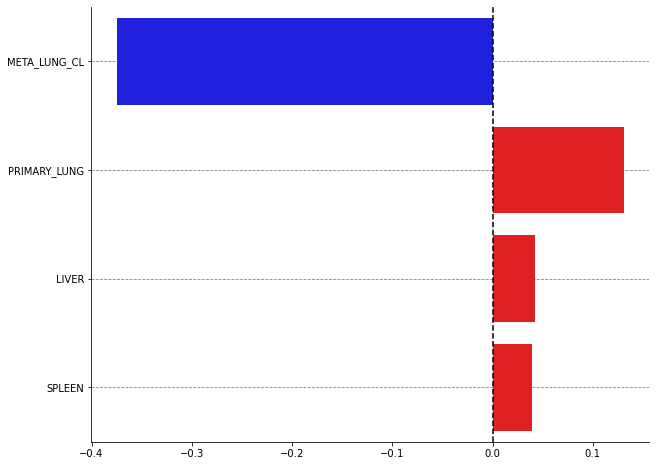

In [15]:
plot_bars(shap_values, names=["META_LUNG_CL", "PRIMARY_LUNG", "LIVER", "SPLEEN"], nbest=15)

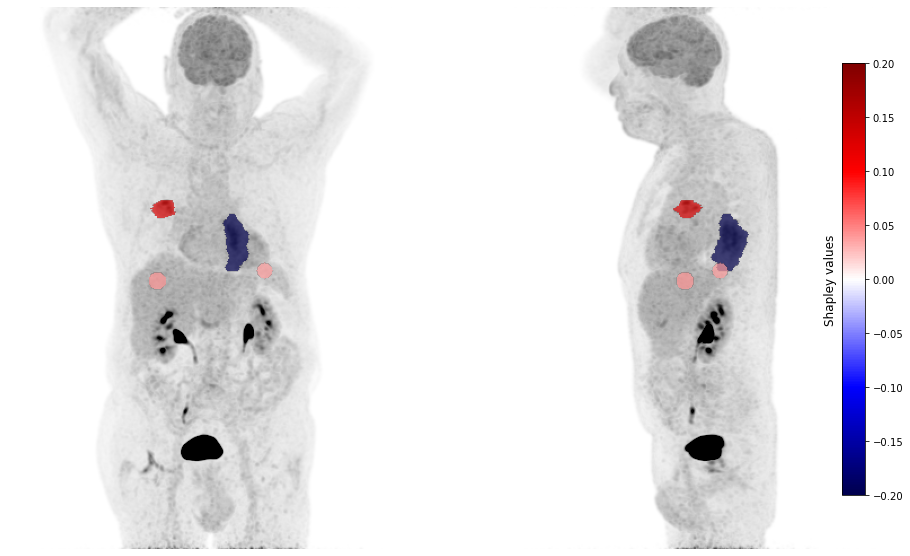

In [16]:
image_path = "E:\\Images\\" + patient + "\\baseline_PET\\PET.nii.gz"
mask_path = "E:\\Images\\" + patient + "\\baseline_PET\\segmentations\\"
mask_paths = []
for name in df_radiomics_all.loc[patient, "localization"].values:
    mask_paths.append(mask_path + name + '.uint16.nii.gz')
    
plot_pet(shap_values, image_path=image_path, masks_paths=mask_paths, cmap_lim = 0.2)